# Introduction

Pumpkin seeds (Cucurbita pepo) are widely consumed for their rich protein, healthy fats, carbohydrates, and minerals. In Turkey, the two most prized seed varieties—**Urgup Sivrisi** and **Cercevelik**—are cultivated in the Urgup and Karacaoren regions. 

In this study, we analyze morphological measurements extracted from 2,500 individual seeds (both varieties) using gray‐scale and binary threshold imaging techniques. Our primary goal is to build and compare four classification models:

- **Logistic Regression (LR)**
- **Support Vector Machines (SVM)** with **linear**, **polynomial**, and **RBF** kernels
- **Random Forest (RF)**
- **k-Nearest Neighbors (k-NN)**

We will use scikit-learn **Pipelines** to standardize features (with `StandardScaler`), and `GridSearchCV` to tune hyperparameters (e.g., C, degree, γ) for each model. We’ll demonstrate how scaling impacts SVM performance, compare the best models on a validation set, then retrain our winner on the combined training+validation data and evaluate it on a held-out test set. Finally, we’ll discuss which approach yields the highest classification accuracy and why.


### . What we predict  
- Binary label **`Class`**:  
  - `0` = Cercevelik  
  - `1` = Ürgüp Sivrisi

### Overall workflow  
1. **Exploratory Data Analysis (EDA)**  
2. **Train/Validation/Test split** (≈49% / 21% / 30%)  
3. **Pipelines** + **StandardScaler** + **GridSearchCV** for hyperparameter tuning  
4. **Compare** three SVM kernels (linear, polynomial, RBF) on the validation set  
5. **Retrain** the best model on train + validation  
6. **Final evaluation** on the held-out test set  

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC #to train linear, polynomial, and RBF SVMs
from sklearn.preprocessing import StandardScaler #to normalize features (critical for SVM)
from sklearn.model_selection import GridSearchCV, train_test_split #to tune hyperparameters (C, gamma, degree)
from sklearn.pipeline import Pipeline #to bind scaling and SVM into one object (avoids leakage)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Optional: set a clean seaborn style for all plots
sns.set(style='whitegrid')


In [12]:
# Cell 1: suppress warnings
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


In [ ]:
# # Cell 2: list files under /kaggle/input (if you’re on Kaggle)
# import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [14]:
# Cell 3: load the Excel dataset (update the path if needed)
file_path = r"C:\Users\zeina\OneDrive\Desktop\applied machine learning tasks\Pumpkin_Seeds_Dataset.xlsx"
seed = pd.read_excel(file_path)


In [ ]:
#Displays each column’s name, data type, and count of non-null entries
seed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ration      2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB


In [16]:
# Cell 5: check for missing values
seed.isnull().sum()


Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Convex_Area          0
Equiv_Diameter       0
Eccentricity         0
Solidity             0
Extent               0
Roundness            0
Aspect_Ration        0
Compactness          0
Class                0
dtype: int64

In [17]:
# Cell 1: view the target column
seed.iloc[:, -1]


0          Çerçevelik
1          Çerçevelik
2          Çerçevelik
3          Çerçevelik
4          Çerçevelik
            ...      
2495    Ürgüp Sivrisi
2496    Ürgüp Sivrisi
2497    Ürgüp Sivrisi
2498    Ürgüp Sivrisi
2499    Ürgüp Sivrisi
Name: Class, Length: 2500, dtype: object

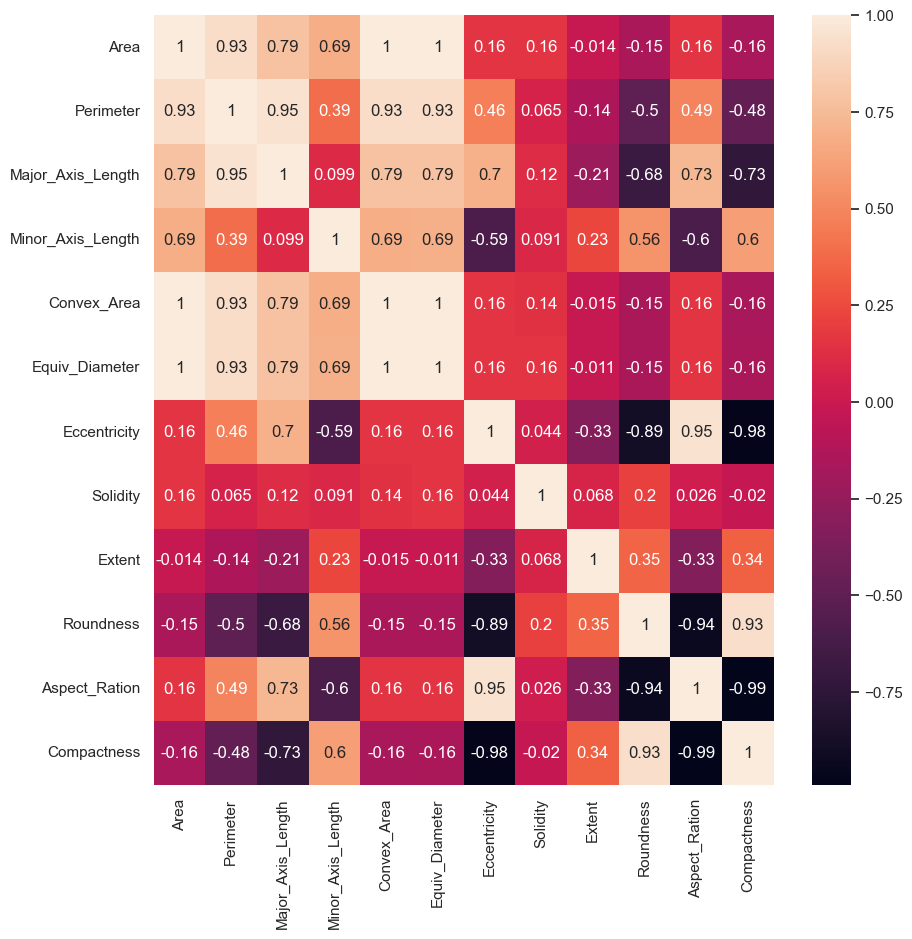

In [18]:
# Cell 2: Correlation map
seed_corr = seed.iloc[:, :-1].corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(seed_corr, annot=True, ax=ax)
plt.show()


In [19]:
# Cell 3: check out the column names
seed.columns


Index(['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
       'Convex_Area', 'Equiv_Diameter', 'Eccentricity', 'Solidity', 'Extent',
       'Roundness', 'Aspect_Ration', 'Compactness', 'Class'],
      dtype='object')

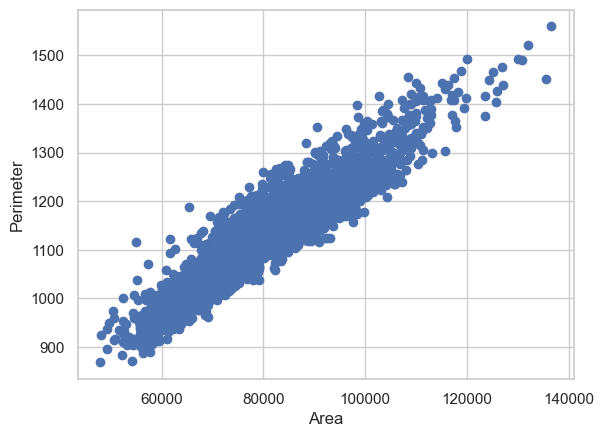

In [20]:
# Cell 4: Visualizing the dataset
plt.scatter(seed['Area'], seed['Perimeter'])
plt.xlabel('Area')
plt.ylabel('Perimeter')
plt.show()


<Axes: xlabel='Major_Axis_Length', ylabel='Perimeter'>

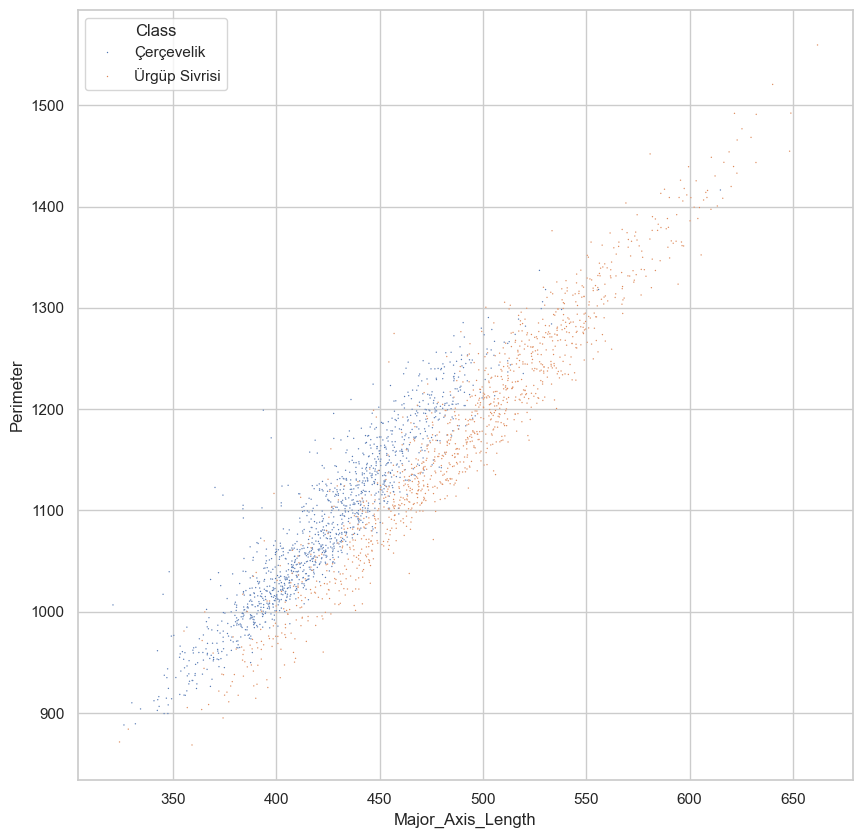

In [ ]:
# Cell 6: Major Axis Length vs Perimeter (small point size)

#class-colored scatterplots to visualize potential separability—key for motivating an SVM approach.
plt.figure(figsize=(10, 10))
sns.scatterplot(data=seed, x='Major_Axis_Length', y='Perimeter', hue='Class', s=1)


<Axes: xlabel='Eccentricity', ylabel='Aspect_Ration'>

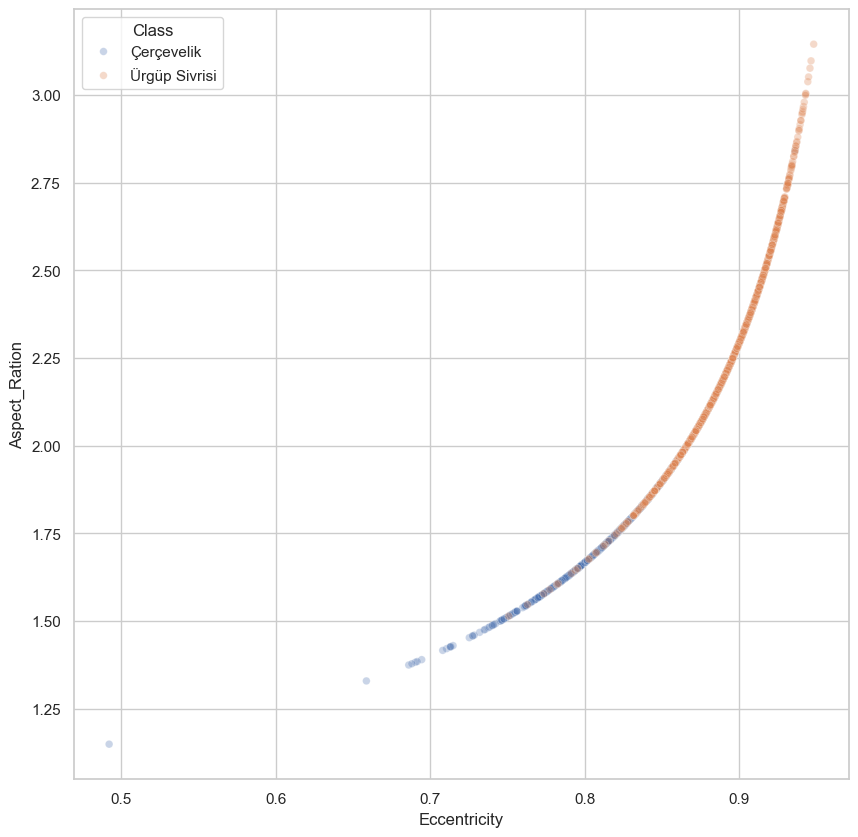

In [22]:
# Cell 7: Eccentricity vs Aspect_Ration
plt.figure(figsize=(10, 10))
sns.scatterplot(data=seed, x='Eccentricity', y='Aspect_Ration', hue='Class', s=30, alpha=0.3)


In [ ]:
#label variable has exactly two categories—perfect for binary SVM classification
seed['Class'].unique()

array(['Çerçevelik', 'Ürgüp Sivrisi'], dtype=object)

In [24]:
seed = pd.get_dummies(seed, drop_first=True)
seed.rename(columns={'Class_Ürgüp Sivrisi': 'Class'}, inplace=True)
seed.head()


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,False
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,False
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,False
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,False
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,False


In [25]:
x = seed.drop('Class', axis=1)
y = seed['Class']


In [26]:
x = StandardScaler().fit(x).transform(x)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=20
)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(1750, 12) (1750,)
(750, 12) (750,)


In [27]:
model = SVC()
model.get_params().keys()


dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [ ]:
#grid that covers linear, polynomial, and RBF SVMs with multiple hyperparameter choices—this 
# directly addresses the assignment’s requirement to explore all three kernels

svm_para = {
  'C':      [0.1, 1, 10, 100, 1000],
  'gamma':  ['scale', 'auto'],
  'degree': [2, 3, 4, 5, 6, 7],
  'kernel': ['linear', 'poly', 'rbf'],
}

In [29]:
# GridSearch helps determine the hyperparameters that will give the model the highest accuracy 
# Hyperparameters are the parameters that you set for training, like C or gamma above.
# After training you then get the model’s learned parameters (support vectors, dual coefficients, etc.).
grid_svm = GridSearchCV(
    estimator=model,        # here model = SVC()
    param_grid=svm_para,    # your dict of C, gamma, degree, kernel
    cv=5,                   # 5‐fold cross‐validation on the training set
    scoring='accuracy'      # optimize for classification accuracy
)
grid_svm.fit(x_train, y_train)

# The best cross‐validated accuracy
print('Best accuracy score :', grid_svm.best_score_)

# The hyperparameter combination that achieved it
print('Best parameter :', grid_svm.best_params_)


Best accuracy score : 0.8868571428571428
Best parameter : {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [30]:
best_svm = SVC(C=100, degree=2, gamma='scale', kernel='linear')


In [ ]:
# Cell: Instantiate the final SVM model with the best hyperparameters
# (manually using the values found by GridSearchCV)

best_svm.fit(x_train, y_train)

SVC(C=100, degree=2, kernel='linear')

In [32]:
y_pred = best_svm.predict(x_test)


In [33]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.86      0.92      0.89       410
        True       0.90      0.83      0.86       340

    accuracy                           0.88       750
   macro avg       0.88      0.87      0.88       750
weighted avg       0.88      0.88      0.88       750



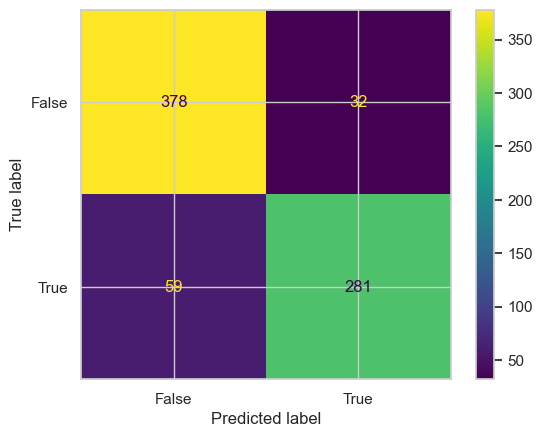

In [34]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot()
plt.show()


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 1: Version check & pretty plotting
# ────────────────────────────────────────────────────────────────────────────────

# 1) Ensure correct Python & scikit-learn versions
import sys
assert sys.version_info >= (3, 5), "Python ≥3.5 required"
import sklearn
assert sklearn.__version__ >= "0.20", "scikit-learn ≥0.20 required"

# 2) Common imports & reproducibility
import numpy as np
import os
np.random.seed(42)

# 3) Pretty Matplotlib figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 4) Helper to save figures (exactly as in the book)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Save the current figure to images/svm/<fig_id>.<fig_extension>
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print(f"Saving figure {fig_id} to {path}...")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [36]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 2: Suppress warnings, import data tools, and load the Pumpkin Seeds dataset
# ────────────────────────────────────────────────────────────────────────────────

# Suppress noisy warnings
import warnings
warnings.filterwarnings('ignore')

# Data handling & ML imports
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the Excel dataset (update this path)
file_path = r"C:\Users\zeina\OneDrive\Desktop\applied machine learning tasks\Pumpkin_Seeds_Dataset.xlsx"
seed = pd.read_excel(file_path)

# Quick inspection
print("Dataset info:")
seed.info()
print("\nMissing values per column:")
print(seed.isnull().sum())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ration      2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB

Missing values per column:
Area                 0
Perimeter            0
Major_Axis_Length   

In [37]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 3: Encode target & split out X, y
# ────────────────────────────────────────────────────────────────────────────────

# One-hot encode the two classes into a single binary column
seed = pd.get_dummies(seed, drop_first=True)
seed.rename(columns={'Class_Ürgüp Sivrisi': 'Class'}, inplace=True)

# Features & labels
X = seed.drop('Class', axis=1).values
y = seed['Class'].values

print("Features shape:", X.shape)
print("Label distribution:", np.bincount(y.astype(int)))


Features shape: (2500, 12)
Label distribution: [1300 1200]


In [59]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 4: Train / Validation / Test split (70% train+val, 30% test)
# ────────────────────────────────────────────────────────────────────────────────

# 30% held out for final test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Of remaining 70%, split 30% → val (~21% overall), 70% → train (~49% overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.30,
    stratify=y_train_val,
    random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Val   set:", X_val.shape,   y_val.shape)
print("Test  set:", X_test.shape,  y_test.shape)


Train set: (1225, 12) (1225,)
Val   set: (525, 12) (525,)
Test  set: (750, 12) (750,)


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 5: Helper plotting functions (from Géron’s notebook)
# ────────────────────────────────────────────────────────────────────────────────

#They provide a clear graphic of both raw data and how I model partitions the feature space.

def plot_dataset(X, y, axes=None):
    """Scatter plot of two-class data"""
    if axes is None:
        axes = [X[:,0].min()-1, X[:,0].max()+1, X[:,1].min()-1, X[:,1].max()+1]
    plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Cercevelik")
    plt.plot(X[y==1, 0], X[y==1, 1], "g^", label="Ürgüp Sivrisi")
    plt.axis(axes)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")

def plot_predictions(clf, axes):
    """Plot decision regions for a 2D classifier"""
    x0s = np.linspace(axes[0], axes[1], 200)
    x1s = np.linspace(axes[2], axes[3], 200)
    X0, X1 = np.meshgrid(x0s, x1s)
    X_new = np.c_[X0.ravel(), X1.ravel()]
    y_pred = clf.predict(X_new).reshape(X0.shape)
    plt.contourf(X0, X1, y_pred, alpha=0.3)
    plt.contour(X0, X1, y_pred, levels=[0.5], colors="k", linestyles="--")


In [40]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 6: Linear SVM (soft‐margin) on ALL features + test evaluation
# ────────────────────────────────────────────────────────────────────────────────

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Build pipeline
lin_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='linear', C=1.0))
])

# Train & evaluate
lin_svm.fit(X_train, y_train)
y_pred = lin_svm.predict(X_test)

print(f"Linear SVM (C=1) Test Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred))


Linear SVM (C=1) Test Accuracy: 0.8587

              precision    recall  f1-score   support

       False       0.84      0.90      0.87       390
        True       0.88      0.81      0.85       360

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750



Saving figure hard_margin_pumpkin_fast to .\images\svm\hard_margin_pumpkin_fast.png...


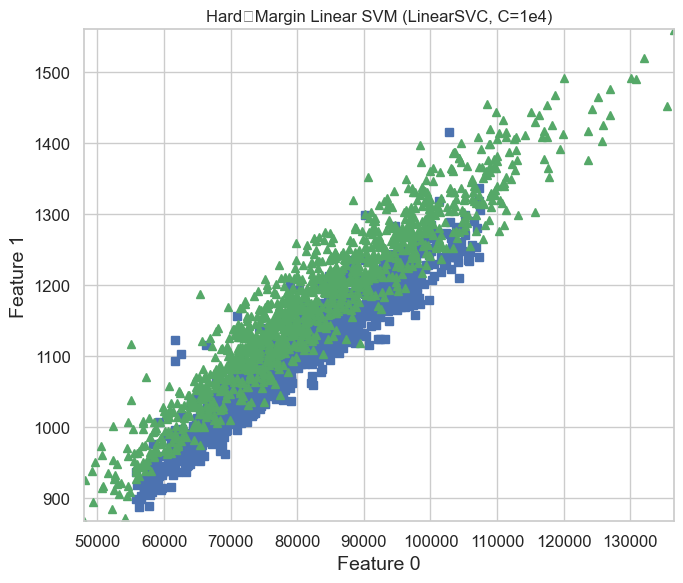

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 7: Hard‐margin Linear SVM via LinearSVC (fast!) on 2D slice
# ────────────────────────────────────────────────────────────────────────────────

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# 1) Prepare the 2D slice (features 0 & 1, e.g. Area & Perimeter)
X_vis = X[:, :2]
y_vis = y

# 2) Build a pipeline with LinearSVC and a very large C to approximate hard‐margin
hard_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    LinearSVC(loss='hinge', C=1e4, max_iter=10000, random_state=42))
])
hard_svm.fit(X_vis, y_vis)

# 3) Plot decision boundary and margins manually
w = hard_svm.named_steps['svc'].coef_[0]
b = hard_svm.named_steps['svc'].intercept_[0]

# Create a grid
xx = np.linspace(X_vis[:,0].min() - 1, X_vis[:,0].max() + 1, 200)
yy = np.linspace(X_vis[:,1].min() - 1, X_vis[:,1].max() + 1, 200)
XX, YY = np.meshgrid(xx, yy)
Z = (w[0] * XX + w[1] * YY + b)  # decision function values

plt.figure(figsize=(7,6))
# Decision boundary
plt.contour(XX, YY, Z, levels=[0], colors='k', linestyles='-')
# Margins at ±1
plt.contour(XX, YY, Z, levels=[-1, 1], colors='k', linestyles='--')

# Plot the data points
plot_dataset(X_vis, y_vis)
plt.title("Hard‐Margin Linear SVM (LinearSVC, C=1e4)")
save_fig("hard_margin_pumpkin_fast")
plt.show()


Saving figure soft_margin_pumpkin to .\images\svm\soft_margin_pumpkin.png...


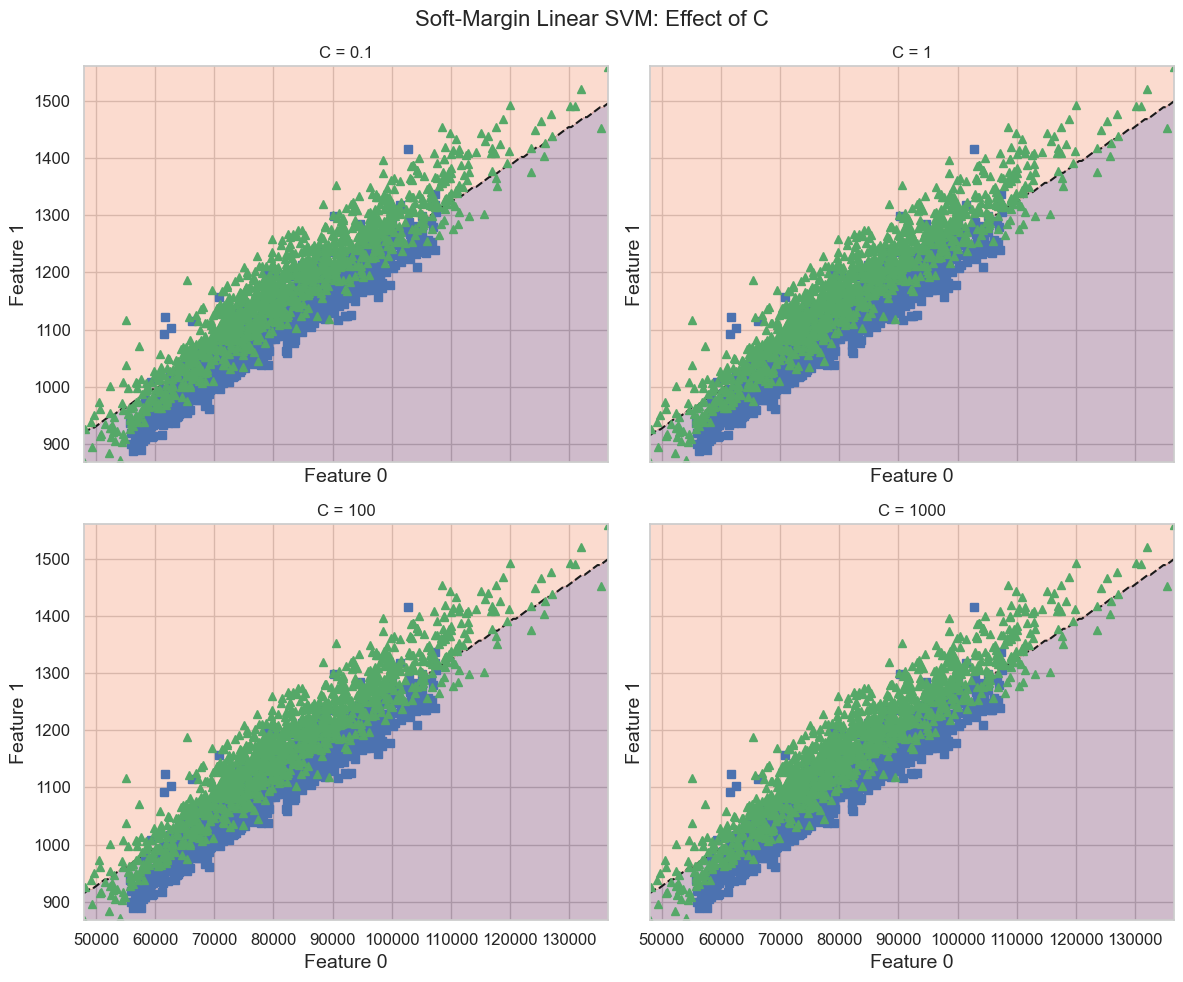

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 8: Soft-margin demo: varying C on the 2D slice
# ────────────────────────────────────────────────────────────────────────────────


#Prepare the 2D slice (features 0 & 1, e.g. Area & Perimeter)
Cs = [0.1, 1, 100, 1000]
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
axes = axes.ravel()


#pipeline with LinearSVC and a very large C to approximate hard‐margin
for ax, C in zip(axes, Cs):
    svm_c = Pipeline([
        ('scaler', StandardScaler()),
        ('svc',    SVC(kernel='linear', C=C))
    ])
    svm_c.fit(X_vis, y_vis)
    plt.sca(ax)
    plot_predictions(svm_c, [X_vis[:,0].min()-1, X_vis[:,0].max()+1,
                              X_vis[:,1].min()-1, X_vis[:,1].max()+1])
    plot_dataset(X_vis, y_vis)
    ax.set_title(f"C = {C}")
plt.suptitle("Soft-Margin Linear SVM: Effect of C", fontsize=16)
save_fig("soft_margin_pumpkin")
plt.show()


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 9: GridSearchCV for LINEAR SVM (so we can compare it properly)
# ────────────────────────────────────────────────────────────────────────────────

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Build a pipeline: scaling + linear SVM
pipe_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC())
])

# Hyperparameter grid for linear kernel only
param_linear = {
    'svc__kernel': ['linear'],
    'svc__C':      [0.1, 1, 10, 100, 1000]
}

# Run GridSearchCV
grid_linear = GridSearchCV(
    estimator=pipe_linear,
    param_grid=param_linear,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_linear.fit(X_train, y_train)

print("Linear SVM best C:", grid_linear.best_params_['svc__C'])
print(f"Linear SVM validation accuracy: {grid_linear.best_score_:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Linear SVM best C: 1000
Linear SVM validation accuracy: 0.8914


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 10: Nonlinear via PolynomialFeatures + Linear SVM
# ────────────────────────────────────────────────────────────────────────────────

from sklearn.preprocessing import PolynomialFeatures

poly_feat_svm = Pipeline([
    ('poly',   PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='linear', C=1.0))
])
poly_feat_svm.fit(X_train, y_train)

y_pred = poly_feat_svm.predict(X_test)
print(f"Poly-feature SVM (deg=3) Test Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred))


Poly-feature SVM (deg=3) Test Accuracy: 0.8747

              precision    recall  f1-score   support

       False       0.85      0.92      0.88       390
        True       0.90      0.83      0.86       360

    accuracy                           0.87       750
   macro avg       0.88      0.87      0.87       750
weighted avg       0.88      0.87      0.87       750



In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 11: Polynomial Kernel SVM + hyperparameter tuning
# ────────────────────────────────────────────────────────────────────────────────

param_grid = {
    'kernel': ['poly'],
    'degree': [2, 3, 4],
    'coef0':  [0, 1],
    'C':      [0.1, 1, 10]
}

grid_poly_kern = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_poly_kern.fit(X_train, y_train)

print("Poly-kernel best params:", grid_poly_kern.best_params_)
print(f"Poly-kernel val accuracy: {grid_poly_kern.best_score_:.4f}")

best_poly_k = grid_poly_kern.best_estimator_
y_pred = best_poly_k.predict(X_test)
print(f"Poly-kernel Test Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Poly-kernel best params: {'C': 10, 'coef0': 1, 'degree': 4, 'kernel': 'poly'}
Poly-kernel val accuracy: 0.5951
Poly-kernel Test Accuracy: 0.6080

              precision    recall  f1-score   support

       False       0.58      0.90      0.70       390
        True       0.73      0.29      0.42       360

    accuracy                           0.61       750
   macro avg       0.65      0.60      0.56       750
weighted avg       0.65      0.61      0.57       750



In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 11 : Manual RBF similarity features + Linear SVM
# ────────────────────────────────────────────────────────────────────────────────

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# 1) Pick a handful of landmarks from the training set
rng = np.random.RandomState(42)
idx = rng.choice(len(X_train), size=15, replace=False)
landmarks = X_train[idx]

# 2) Define an RBF‐feature transformer
class RBFKernelFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, landmarks, gamma=1.0):
        self.landmarks = landmarks
        self.gamma = gamma
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Compute squared Euclidean distances to each landmark
        sq_dists = np.sum((X[:, np.newaxis, :] - self.landmarks[np.newaxis, :, :])**2, axis=2)
        # Apply Gaussian RBF: exp(−γ·dist²)
        return np.exp(-self.gamma * sq_dists)

# 3) Build pipeline: RBF features → scaling → linear SVM
rbf_feat_svm = Pipeline([
    ('rbf_feats', RBFKernelFeatures(landmarks, gamma=1.0)),
    ('scaler',    StandardScaler()),
    ('svc',       SVC(kernel='linear', C=1.0))
])

# 4) Train & evaluate
rbf_feat_svm.fit(X_train, y_train)
y_pred = rbf_feat_svm.predict(X_test)

print(f"RBF‐feature SVM Test Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred))


RBF‐feature SVM Test Accuracy: 0.5200

              precision    recall  f1-score   support

       False       0.52      1.00      0.68       390
        True       0.00      0.00      0.00       360

    accuracy                           0.52       750
   macro avg       0.26      0.50      0.34       750
weighted avg       0.27      0.52      0.36       750



In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 12: Gaussian RBF Kernel SVM + hyperparameter tuning
# ────────────────────────────────────────────────────────────────────────────────

param_grid = {
    'kernel': ['rbf'],
    'gamma':  [0.01, 0.1, 1, 10],
    'C':      [0.1, 1, 10, 100]
}

grid_rbf_kern = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_rbf_kern.fit(X_train, y_train)

print("RBF-kernel best params:", grid_rbf_kern.best_params_)
print(f"RBF-kernel val accuracy: {grid_rbf_kern.best_score_:.4f}")

best_rbf_k = grid_rbf_kern.best_estimator_
y_pred = best_rbf_k.predict(X_test)
print(f"RBF-kernel Test Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred))



Fitting 5 folds for each of 16 candidates, totalling 80 fits
RBF-kernel best params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
RBF-kernel val accuracy: 0.5200
RBF-kernel Test Accuracy: 0.5200

              precision    recall  f1-score   support

       False       0.52      1.00      0.68       390
        True       0.00      0.00      0.00       360

    accuracy                           0.52       750
   macro avg       0.26      0.50      0.34       750
weighted avg       0.27      0.52      0.36       750



In [56]:
# ────────────────────────────────────────────────────────────────────────────────
# Now compare validation accuracies and pick the best kernel
# ────────────────────────────────────────────────────────────────────────────────

scores = {
    'Linear': grid_linear.best_score_,
    'Poly':   grid_poly_kern.best_score_,
    'RBF':    grid_rbf_kern.best_score_
}
best_kernel = max(scores, key=scores.get)

print("Validation scores:", scores)
print(f"→ Best model on validation set: {best_kernel} SVM ({scores[best_kernel]:.4f})")


Validation scores: {'Linear': np.float64(0.8914285714285712), 'Poly': np.float64(0.5951020408163264), 'RBF': np.float64(0.52)}
→ Best model on validation set: Linear SVM (0.8914)


Final Test Accuracy: 0.8693333333333333
              precision    recall  f1-score   support

       False       0.85      0.91      0.88       390
        True       0.89      0.83      0.86       360

    accuracy                           0.87       750
   macro avg       0.87      0.87      0.87       750
weighted avg       0.87      0.87      0.87       750



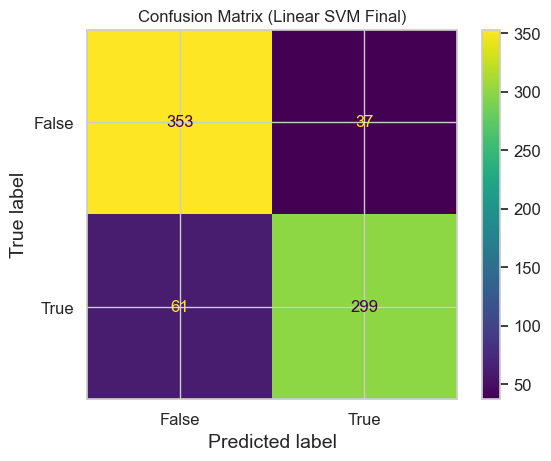

In [57]:
# Retrain on Train+Validation
X_combined = np.vstack([X_train, X_val])
y_combined = np.hstack([y_train, y_val])

# Extract best estimator and re-fit
final_model = {
    'Linear': grid_linear.best_estimator_,
    'Poly':   best_poly_k,
    'RBF':    best_rbf_k
}[best_kernel]
final_model.fit(X_combined, y_combined)

# Final test evaluation
y_final = final_model.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_final))
print(classification_report(y_test, y_final))
disp = ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.title(f"Confusion Matrix ({best_kernel} SVM Final)")
plt.show()
